In [1]:
# Test core geospatial libraries
import geopandas as gpd
import rasterio
import xarray as xr
import rioxarray
import leafmap
import pandas as pd
import numpy as np

print("✓ All core libraries imported successfully!")

✓ All core libraries imported successfully!


# Creating an interactive map using Leafmap

In [51]:
m = leafmap.Map(center=[40, -100], zoom=4, height="500px")

# different basemap options
m.add_basemap("OpenTopoMap")
m.add_basemap("USGS.Imagery")

# Creating Points from Coordinate Data

### Create a GeoDataFrame from coordinate data

In [8]:
data = {
    "City": ["Tokyo", "New York", "London", "Paris"],
    "Latitude": [35.6895, 40.7128, 51.5074, 48.8566],
    "Longitude": [139.6917, -74.0060, -0.1278, 2.3522],
}

df = pd.DataFrame(data)

### Convert to GeoDataFrame by creating Point geometries from coordinates

In [9]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf

,City,Latitude,Longitude,geometry
0,Tokyo,35.6895,139.6917,POINT (139.6917 35.6895)
1,New York,40.7128,-74.0060,POINT (-74.006 40.7128)
2,London,51.5074,-0.1278,POINT (-0.1278 51.5074)
3,Paris,48.8566,2.3522,POINT (2.3522 48.8566)


### Reading a GeoJSON File

GeoJSON is a widely used open standard format for encoding geographic data structures using JavaScript Object Notation (JSON). It represents geographic features like points, lines, and polygons, along with their associated attributes, in a text-based format.

In [25]:
url = "https://github.com/opengeos/datasets/releases/download/vector/nybb.geojson"
gdf = gpd.read_file(url)
gdf.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


## Projections and Coordinate Reference Systems (CRS)

In [26]:
print(f"Current CRS: {gdf.crs}")

Current CRS: EPSG:2263


In [27]:
# Reproject to WGS84 (latitude/longitude) for global compatibility
gdf_4326 = gdf.to_crs(epsg=4326)
print(f"Reprojected CRS: {gdf_4326.crs}")
gdf_4326.head()

Reprojected CRS: EPSG:4326


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


## Spatial Measurements and Analysis

In [28]:
# Reprojecting to Web Mercator for accurate area calculations in square meters
gdf = gdf.to_crs("EPSG:3857")

gdf = gdf.set_index("BoroName") 
print(f"Now using CRS: {gdf.crs}")

Now using CRS: EPSG:3857


In [31]:
# Calculate area in square meters
gdf["area"] = gdf.area

# Convert to more readable units (square kilometers)
gdf["area_km^2"] = gdf["area"] / 1_000_000

# Display results sorted by area
gdf[["area", "area_km^2"]].sort_values("area_km^2", ascending=False)

,area,area_km^2
BoroName,,
Queens,4.928316e+08,492.831621
Brooklyn,3.129694e+08,312.969358
Staten Island,2.618035e+08,261.803516
Bronx,1.929251e+08,192.925108
Manhattan,1.032201e+08,103.220100


In [32]:
# Extract boundary lines from polygons
gdf["boundary"] = gdf.boundary

# Calculate centroids (geometric centers)
gdf["centroid"] = gdf.centroid

# Display the geometric features
gdf[["boundary", "centroid"]].head()

,boundary,centroid
BoroName,,
Staten Island,"MULTILINESTRING ((-8243264.851 4948597.836, -8...",POINT (-8254713.541 4950718.061)
Queens,"MULTILINESTRING ((-8219461.925 4952778.732, -8...",POINT (-8217436.751 4969318.726)
Brooklyn,"MULTILINESTRING ((-8222843.672 4950893.793, -8...",POINT (-8231817.467 4960085.273)
Manhattan,"MULTILINESTRING ((-8238858.864 4965915.024, -8...",POINT (-8233984.803 4979551.765)
Bronx,"MULTILINESTRING ((-8226155.13 4982269.949, -82...",POINT (-8222783.631 4990631.242)


In [33]:
# Use Manhattan's centroid as the reference point
manhattan_centroid = gdf.loc["Manhattan", "centroid"]

# Calculate distance from each borough centroid to Manhattan
gdf["distance_to_manhattan"] = gdf["centroid"].distance(manhattan_centroid)

# Convert to kilometers and display results
gdf["distance_to_manhattan_km"] = gdf["distance_to_manhattan"] / 1000

gdf[["distance_to_manhattan_km"]].sort_values("distance_to_manhattan_km")

,distance_to_manhattan_km
BoroName,
Manhattan,0.000000
Bronx,15.755034
Queens,19.456442
Brooklyn,19.586772
Staten Island,35.511450


## Visualizing Geospatial Data

In [35]:
import matplotlib.pyplot as plt

# Set high resolution for better quality plots
plt.rcParams["figure.dpi"] = 150

Matplotlib is building the font cache; this may take a moment.


### Thematic Mapping

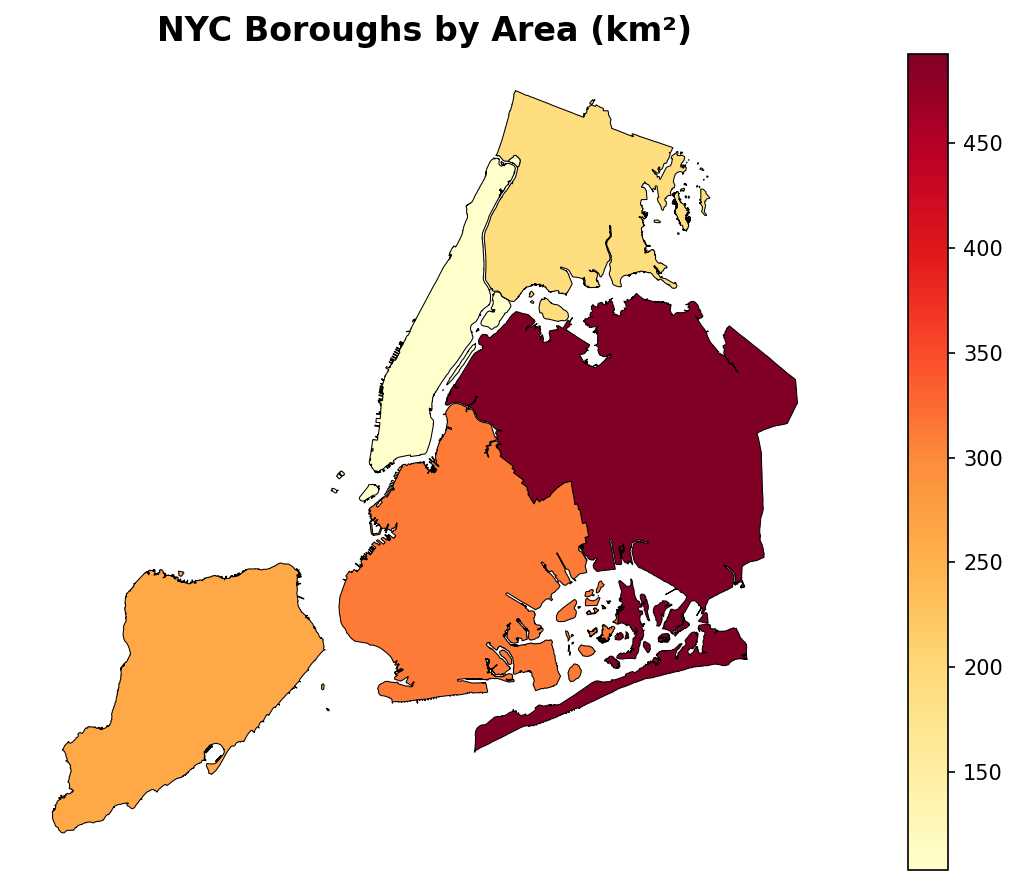

In [36]:
# Create a choropleth map showing borough areas
fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(
    column="area_km2",
    ax=ax,
    legend=True,
    cmap="YlOrRd",  # Yellow-Orange-Red colormap
    edgecolor="black",
    linewidth=0.5,
)

plt.title("NYC Boroughs by Area (km²)", fontsize=16, fontweight="bold")
plt.axis("off")  # Remove coordinate axes for cleaner appearance
plt.tight_layout()
plt.show()

### Multi-Layer Visualization

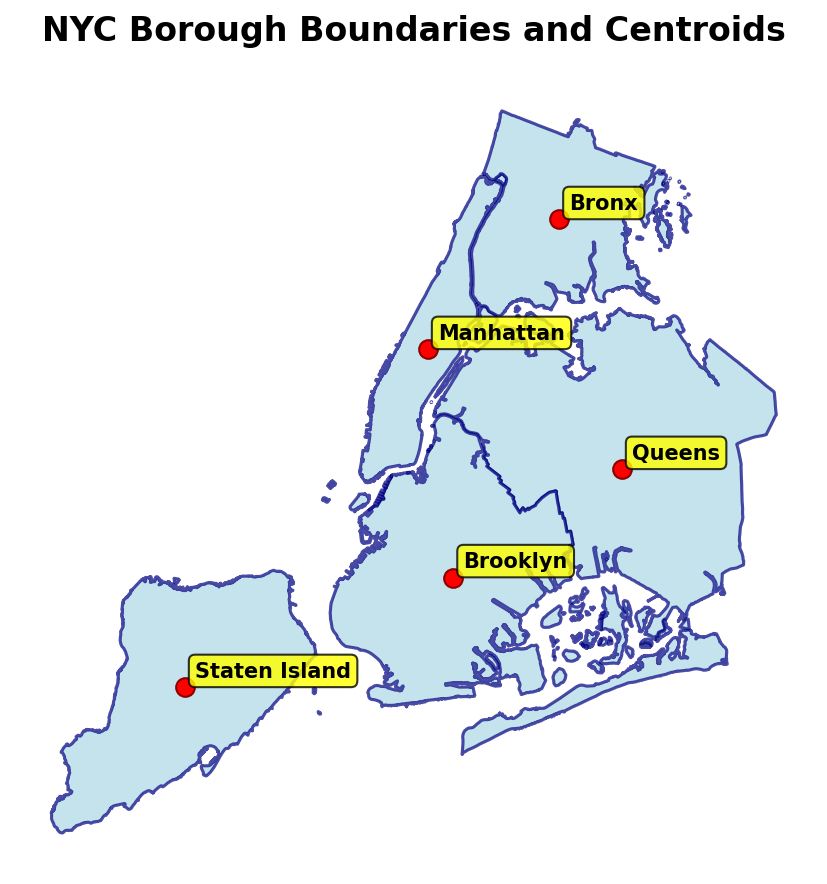

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

gdf["geometry"].plot(
    ax=ax, color="lightblue", edgecolor="navy", linewidth=1.5, alpha=0.7
)

gdf["centroid"].plot(
    ax=ax, color="red", markersize=80, edgecolor="darkred", linewidth=1
)

for idx, row in gdf.iterrows():
    
    # Getting centroid coordinates for label placement
    
    x = row.centroid.x
    y = row.centroid.y
    
    ax.annotate(
        idx,
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
    )

plt.title("NYC Borough Boundaries and Centroids", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

### Interactive 

Creating an interactive map using Folium integration

In [40]:
m = gdf.explore(
    column="area_km2",
    cmap="YlOrRd",
    tooltip=["area_km2", "distance_to_manhattan_km"],
    popup=True,
    legend=True,
)
m

# Advanced Geometric Operations

### Buffer Analysis

In [43]:
# Creating 3-kilometer buffer zones around each borough
buffer_distance = 3000  # meters
gdf["buffered"] = gdf.buffer(buffer_distance)

print(f"Created {buffer_distance/1000} km buffer zones around each borough")

Created 3.0 km buffer zones around each borough


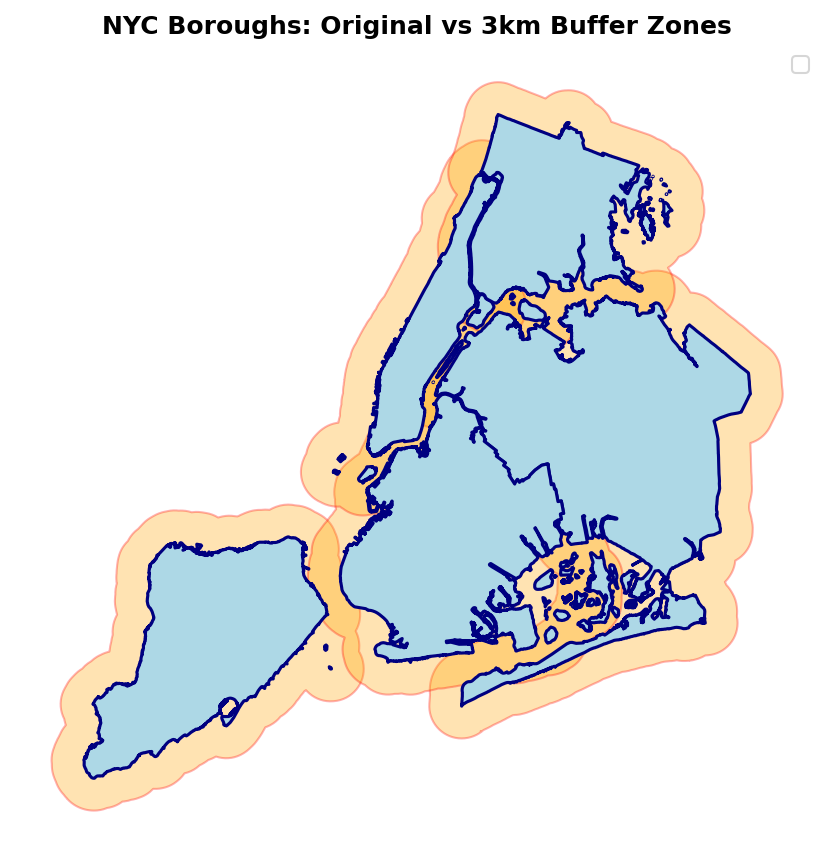

In [45]:
# Visualize original vs buffered geometries
fig, ax = plt.subplots(figsize=(10, 6))

# Plot buffered areas first (background)
gdf["buffered"].plot(
    ax=ax,
    alpha=0.3,
    color="orange",
    edgecolor="red",
    linewidth=1,
    label="3km Buffer Zone",
)

# Plot original geometries on top
gdf["geometry"].plot(
    ax=ax,
    color="lightblue",
    edgecolor="navy",
    linewidth=1.5,
    label="Original Boundaries",
)

plt.title("NYC Boroughs: Original vs 3km Buffer Zones", fontsize=12, fontweight="bold")
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.show()

### Convex Hull Analysis

The smallest boundary that enclose a vector data aka points, polygons, lines. 

In [46]:
# Calculate convex hulls for each borough
gdf["convex_hull"] = gdf.convex_hull

# Compare areas between original shapes and convex hulls
gdf["convex_hull_area"] = gdf["convex_hull"].area / 1_000_000  # Convert to km²
gdf["area_ratio"] = gdf["convex_hull_area"] / gdf["area_km2"]

print("Convex Hull Analysis:")
print(gdf[["area_km2", "convex_hull_area", "area_ratio"]].round(2))

Convex Hull Analysis:
               area_km2  convex_hull_area  area_ratio
BoroName                                             
Staten Island    261.80            332.54        1.27
Queens           492.83            845.79        1.72
Brooklyn         312.97            405.32        1.30
Manhattan        103.22            178.16        1.73
Bronx            192.93            269.55        1.40


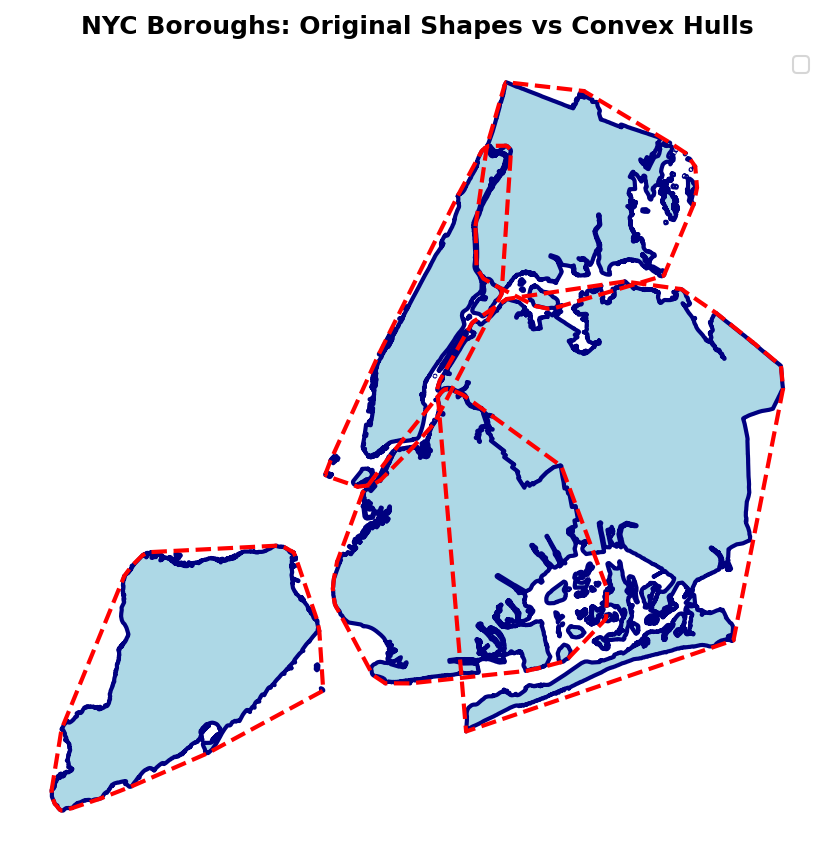

In [48]:
# Create comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original geometries
gdf["geometry"].plot(
    ax=ax, color="lightblue", edgecolor="navy", linewidth=2, label="Original Shape"
)

# Plot convex hulls as outlines
gdf["convex_hull"].plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    linestyle="--",
    label="Convex Hull",
)

plt.title(
    "NYC Boroughs: Original Shapes vs Convex Hulls", fontsize=12, fontweight="bold"
)
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.show()

# Spatial Relationships and Queries

### Intersection Analysis

In [49]:
# Test which buffered boroughs intersect with Manhattan's original boundary
manhattan_geom = gdf.loc["Manhattan", "geometry"]

gdf["intersects_manhattan"] = gdf["buffered"].intersects(manhattan_geom)
gdf["touches_manhattan"] = gdf["geometry"].touches(manhattan_geom)

# Display results
intersection_results = gdf[["intersects_manhattan", "touches_manhattan"]]
intersection_results

,intersects_manhattan,touches_manhattan
BoroName,,
Staten Island,False,False
Queens,True,True
Brooklyn,True,True
Manhattan,True,False
Bronx,True,True


In [50]:
# Verify that centroids fall within their respective borough boundaries
gdf["centroid_within_borough"] = gdf["centroid"].within(gdf["geometry"])

# Check for any anomalies
anomalies = gdf[~gdf["centroid_within_borough"]]
if len(anomalies) > 0:
    print("Warning: Some centroids fall outside their borough boundaries")
    print(anomalies.index.tolist())
else:
    print("✓ All centroids correctly fall within their borough boundaries")

✓ All centroids correctly fall within their borough boundaries
